In [47]:
import matplotlib.pyplot as plt
import pandas as pd
import pylab as pl
import numpy as np
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
import joblib
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RepeatedKFold ,cross_validate 


In [2]:
df=pd.read_csv('../Data/HouseImformation.csv')

In [3]:
df['Area'] = df['Area'].str.replace(',', '').astype(float)

df=df.dropna()

isoOuter=IsolationForest(contamination=0.01)
df['OuterData']=isoOuter.fit_predict(df[["Area", "Price"]])

df=df.drop(index=df[df['OuterData'] == -1].index)

MeanPriceAddressOuter=df.groupby("Address")["Price"].mean()
df["MeanPriceA"] = df["Address"].map(MeanPriceAddressOuter)

In [4]:
from sklearn.preprocessing import StandardScaler

scaler=StandardScaler()
x_Data = scaler.fit_transform(df[['Area','Room','Parking','Warehouse','Elevator','MeanPriceA']])
y_Data=df['Price'].values


In [5]:
mask= np.random.rand(len(df)) < 0.8

train=df[mask]
test=df[~mask]

x_train=np.asanyarray(train[['Area','Room','Parking','Warehouse','Elevator','MeanPriceA']])
y_train=np.asanyarray(train['Price'])

x_test=np.asanyarray(test[['Area','Room','Parking','Warehouse','Elevator','MeanPriceA']])
y_test=np.asanyarray(test['Price'])

In [48]:
from sklearn.ensemble import GradientBoostingRegressor

##If I Increase learning rate Mean=>Decrease
#for n_estimators 150 is the Best Mean And Standard deviation
model=GradientBoostingRegressor(n_estimators=150,max_depth=3,learning_rate=0.1)

cv=RepeatedKFold(n_splits=10,n_repeats=3,random_state=1)

CrossVal=cross_validate(model,x_Data,y_Data,cv=cv,scoring='r2',return_train_score=True)

print("Train Scores:", CrossVal['train_score'])
print("Mean Train Score:", CrossVal['train_score'].mean())

print("Test Scores:", CrossVal['test_score'])
print("Mean Test Score:", CrossVal['test_score'].mean())




Train Scores: [0.92951603 0.92632596 0.92202063 0.92612765 0.92529125 0.92915093
 0.92809438 0.9264081  0.92818131 0.92647016 0.92426066 0.92971121
 0.92521329 0.92714838 0.93261821 0.92200541 0.92905881 0.92893995
 0.92984437 0.9239857  0.92615681 0.93170055 0.9227597  0.92658673
 0.92891003 0.93132689 0.92734928 0.92737395 0.92859336 0.9280687 ]
Mean Train Score: 0.9273066126287012
Test Scores: [0.85453865 0.85403502 0.88573456 0.88702383 0.86466631 0.86835604
 0.85044709 0.88587979 0.84783246 0.84887048 0.88878621 0.86772284
 0.87748533 0.85577123 0.86555716 0.91433245 0.86913065 0.79890326
 0.84107673 0.86989297 0.85747314 0.83301866 0.87717342 0.88059083
 0.85712783 0.81297376 0.90843436 0.87244213 0.88396709 0.85901559]
Mean Test Score: 0.8646086627965855


In [41]:
modelFit=GradientBoostingRegressor(n_estimators=100,max_depth=3,learning_rate=0.1)


modelFit.fit(x_train,y_train)

y_predict=modelFit.predict(x_test)
y_train_predict=modelFit.predict(x_train)

from sklearn.metrics import r2_score
print(f"Test R2 Score: {r2_score(y_test, y_predict):.2f}")
print(f"Train R2 Score: {r2_score(y_train, y_train_predict):.2f}")

Test R2 Score: 0.89
Train R2 Score: 0.92


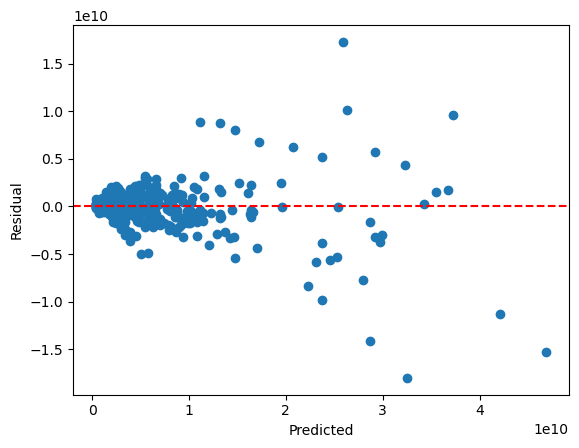

In [49]:
residuals = y_test - y_predict
plt.scatter(y_predict, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted")
plt.ylabel("Residual")
plt.show()

In [51]:
from sklearn.metrics import mean_absolute_error

print("MAE:", mean_absolute_error(y_test, y_predict))

MAE: 956499068.3028767
